# Analiza eksperymentu A/B na podstawie logów

* Logi z serwisu zawierają dla każdej predykcji
  * id użytkownika
  * użyty model
  * id listingu
  * wartość predykcji
* Nie zawierają parametrów wywołania, ale można je odtworzyć na podstawie id listingu

TODO: ustalić na konsultacjach co i jak właściwie mamy tu liczyć,
bo nie ma w tym przypadku oczywistego sposobu jak określić który model jest lepszy
chyba że byśmy dysponowali średnimi ocenami dla tych listingów, które pojawią się w systemie po jakimś czasie

In [1]:
import json
import re

import matplotlib.pyplot as plt
import pandas as pd

LOG_FILE = "../data/service.log"
BASE_MODEL_NAME = "RandomBaseModel"
NEW_MODEL_NAME = "LinearRegressionModel"

In [2]:
regex = re.compile(
    r"user (?P<user_id>[a-f0-9\-]+), given listing (?P<listing_id>\d+), using model (?P<model_name>\w+): (?P<prediction>[0-9.]+)")
regex = re.compile(
    r"Predicted (?P<prediction>[0-9.]+) for user (?P<user_id>[a-f0-9\-]+), using model (?P<model_name>\w+), given params: (?P<params>\{.*\})")


def parse_log_line(log_line: str):
    log_line = log_line.strip()
    parsed = re.search(regex, log_line).groupdict()
    params_dict = json.loads(parsed["params"])
    parsed.pop("params")
    for key, val in params_dict.items():
        parsed[key] = val

    return parsed


with open(LOG_FILE) as f:
    logs = pd.DataFrame([
        parse_log_line(line)
        for line in f
        if "PredictionService" in line
    ])

logs

,prediction,user_id,model_name,id,listing_url,scrape_id,last_scraped,source,name,description,...,availability_30,availability_60,availability_90,availability_365,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,4.772081059596061,617d32dc-5c87-4ac6-a89d-b991624c529b,RandomBaseModel,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",...,23,50,78,78,08/Z/AZ/014226-24,t,1,0,1,0
1,4.794981703732043,617d32dc-5c87-4ac6-a89d-b991624c529e,LinearRegressionModel,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",...,23,50,78,78,08/Z/AZ/014226-24,t,1,0,1,0
2,4.794981703732043,617d32dc-5c87-4ac6-a89d-b991624c529e,LinearRegressionModel,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",...,23,50,78,78,08/Z/AZ/014226-24,t,1,0,1,0
3,4.794981703732043,617d32dc-5c87-4ac6-a89d-b991624c529e,LinearRegressionModel,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",...,23,50,78,78,08/Z/AZ/014226-24,t,1,0,1,0
4,4.794981703732043,617d32dc-5c87-4ac6-a89d-b991624c529e,LinearRegressionModel,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",...,23,50,78,78,08/Z/AZ/014226-24,t,1,0,1,0
5,4.794981703732043,617d32dc-5c87-4ac6-a89d-b991624c529e,LinearRegressionModel,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",...,23,50,78,78,08/Z/AZ/014226-24,t,1,0,1,0
6,4.794981703732043,617d32dc-5c87-4ac6-a89d-b991624c529e,LinearRegressionModel,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",...,23,50,78,78,08/Z/AZ/014226-24,t,1,0,1,0
7,4.983815025709316,617d32dc-5c87-4ac6-a89d-b991624c529b,RandomBaseModel,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",...,23,50,78,78,08/Z/AZ/014226-24,t,1,0,1,0
8,4.951134200905593,617d32dc-5c87-4ac6-a89d-b991624c529b,RandomBaseModel,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",...,23,50,78,78,08/Z/AZ/014226-24,t,1,0,1,0
9,4.179310281898124,617d32dc-5c87-4ac6-a89d-b991624c529b,RandomBaseModel,1047164111839138424,https://www.nocarz.pl/rooms/1047164111839138424,20241221052002,2024-12-21,city scrape,Privatzimmer in Neukölln/Rixdorf (Erdgeschoß),"Hey dear guests, <br /><br />the room has a be...",...,23,50,78,78,08/Z/AZ/014226-24,t,1,0,1,0


In [3]:
logs_a = logs[logs["model_name"] == BASE_MODEL_NAME]
logs_b = logs[logs["model_name"] == NEW_MODEL_NAME]

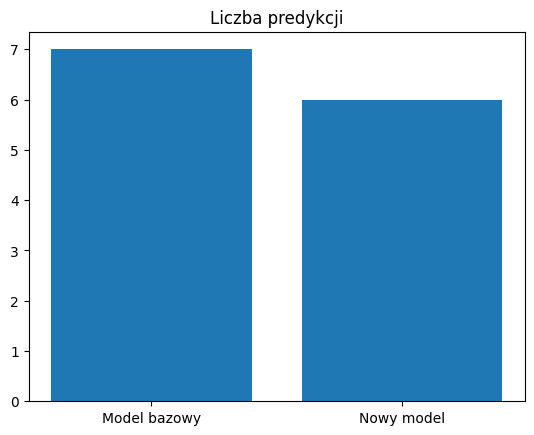

In [4]:
plt.bar(x=["Model bazowy", "Nowy model"], height=[len(logs_a), len(logs_b)])
plt.title("Liczba predykcji")
plt.show()

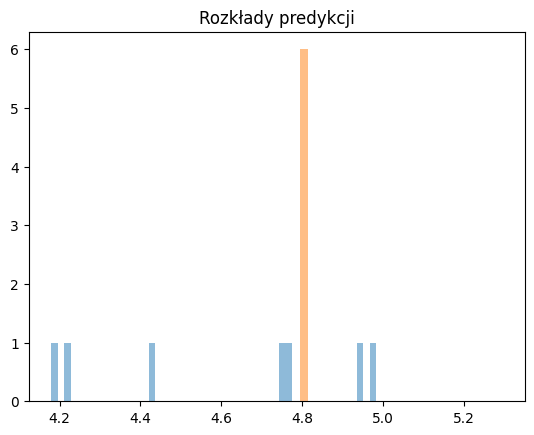

In [5]:
plt.hist(logs_a["prediction"].astype(float), bins=50, alpha=0.5, label="Model bazowy")
plt.hist(logs_b["prediction"].astype(float), bins=50, alpha=0.5, label="Nowy model")
plt.title("Rozkłady predykcji")
plt.show()